In [ ]:
%pip install tensorflow
%pip install numpy
%pip install pandas
%pip install ast
%pip install logging
%pip install ast
%pip install seaborn
%pip install mlflow


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached AST-0.0.2.tar.gz (19 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [8 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/private/var/folders/d8/yhrnl4gn78vbcvy365vfz_q00000gp/T/pip-install-w4ao_oui/ast_e08592c0ec914814ba37ffe63ab36e39/setup.py", line 6, in <module>
          README = codecs.open(os.path.join(here, 'AST/README'), encoding='utf8').read()
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "<frozen codecs>", line 918, in open
      FileNotFoundError: [Errno 2] No such file or di

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import ast
import logging
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

2024-11-12 14:55:12.882908: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:root:Starting data preprocessing
INFO:root:561 rows remain after filtering
INFO:root:Creating the model
INFO:root:Model created successfully


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5595 - loss: 0.6929 - val_accuracy: 0.5556 - val_loss: 0.6917 - learning_rate: 0.0010
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5944 - loss: 0.6887 - val_accuracy: 0.5556 - val_loss: 0.6874 - learning_rate: 0.0010
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5892 - loss: 0.6806 - val_accuracy: 0.5556 - val_loss: 0.6894 - learning_rate: 0.0010
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6047 - loss: 0.6767 - val_accuracy: 0.5556 - val_loss: 0.6936 - learning_rate: 0.0010
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5974 - loss: 0.6768Epoch 5: loss = 0.6780, accuracy = 0.5894, val_loss = 0.6893, val_accuracy = 0.5556
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5968 - loss: 0.6769 - val_accuracy: 0.5556 - val_loss: 0.6893 - learning_rate: 0.0010
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5973 - loss: 0.6716 - val_accur

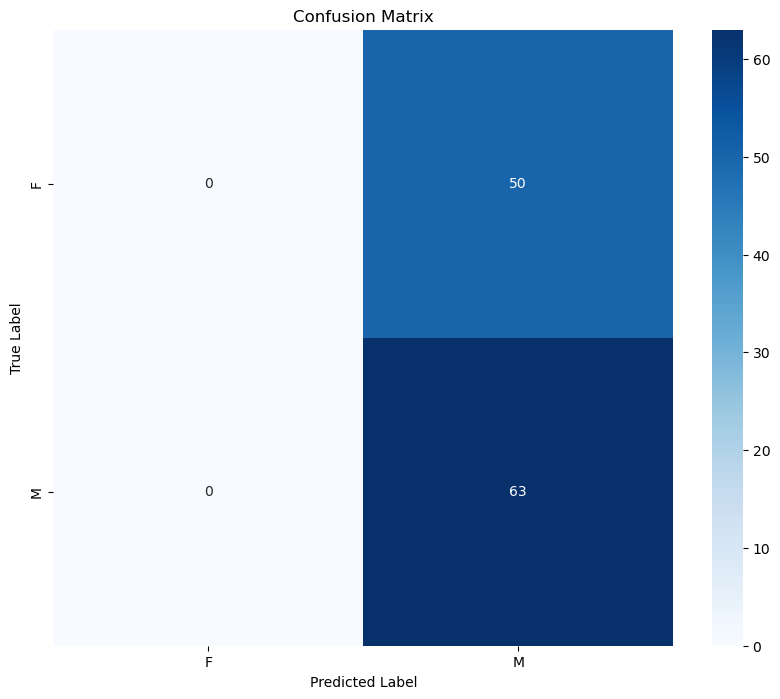

INFO:root:Model saved at trained_model.keras



              precision    recall  f1-score   support

           F       1.00      0.00      0.00        50
           M       0.56      1.00      0.72        63

    accuracy                           0.56       113
   macro avg       0.78      0.50      0.36       113
weighted avg       0.75      0.56      0.40       113



In [3]:
# Initialize logging
logging.basicConfig(level=logging.INFO)

def preprocess_data(data_path):
    """
    Preprocesses the data by loading, validating, and filtering it.
    
    Args:
        data_path (str): Path to the CSV file containing data.
    
    Returns:
        tuple: (padded_sequences, labels, classes)
    """
    logging.info('Starting data preprocessing')

    try:
        # Load the data
        df = pd.read_csv(data_path)
        
        # Validate 'Babbles' column
        if 'Babbles' not in df.columns or df['Babbles'].isnull().any():
            raise ValueError("The 'Babbles' column is missing or contains NaN values.")
        
        # Convert strings to lists and filter by length
        df['Babbles'] = df['Babbles'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
        
        df = df[df['Babbles'].apply(lambda x: len(x) >= 50)]
        logging.info(f'{len(df)} rows remain after filtering')
        
        # Pad sequences
        sequences = df['Babbles'].values
        padded_sequences = tf.keras.utils.pad_sequences(sequences, padding='post', dtype='float32')
        
        # Encode labels
        le = LabelEncoder()
        labels = le.fit_transform(df['Sex'])
        
        return padded_sequences, labels, le.classes_

    except FileNotFoundError:
        logging.error(f"File {data_path} not found.")
        raise
    except Exception as e:
        logging.error(f"Error during preprocessing: {e}")
        raise

def create_model(input_length, num_classes):
    """
    Creates and returns a compiled GRU model.
    
    Args:
        input_length (int): Length of input sequences.
        num_classes (int): Number of output classes.
    
    Returns:
        tf.keras.Model: The compiled model.
    """
    logging.info('Creating the model')
    
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_length, 1)),
        tf.keras.layers.GRU(64, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.GRU(32),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    logging.info('Model created successfully')
    return model

def plot_confusion_matrix(y_true, y_pred, classes):
    """
    Plots the confusion matrix.
    
    Args:
        y_true (array): True labels.
        y_pred (array): Predicted labels.
        classes (list): Class names.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Custom callback for detailed training progress
class TrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch + 1}: loss = {logs["loss"]:.4f}, '
                  f'accuracy = {logs["accuracy"]:.4f}, '
                  f'val_loss = {logs["val_loss"]:.4f}, '
                  f'val_accuracy = {logs["val_accuracy"]:.4f}')

def main():
    # Preprocess data
    try:
        X, y, classes = preprocess_data('CMBabble_Master_Sex_scm.csv')
    except Exception as e:
        logging.error(f"Preprocessing failed: {e}")
        return
    
    # Reshape and split data
    X = X.reshape(X.shape[0], X.shape[1], 1)
    y = tf.keras.utils.to_categorical(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create and train model
    model = create_model(X.shape[1], len(classes))
    
    callbacks = [
        TrainingCallback(),
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss', 
            patience = 20, 
            restore_best_weights = True),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor = 'val_loss',
            factor = 0.5, 
            patience = 10, 
            min_lr = 0.0001)
    ]
    
    history = model.fit(
        X_train, y_train,
        epochs = 50,  # Adjust for practical training time
        batch_size = 32,
        validation_split = 0.2,
        callbacks = callbacks,
        verbose = 1
    )

    # Function to predict on new sequences
    def predict_sequence(sequence):
        try:
            # Ensure sequence is in correct format
            sequence = np.array(sequence)
            sequence = tf.keras.utils.pad_sequences([sequence], maxlen=X.shape[1], padding='post')
            sequence = sequence.reshape(1, X.shape[1], 1)
            
            # Make prediction
            prediction = model.predict(sequence)
            predicted_class = classes[np.argmax(prediction)]
            confidence = np.max(prediction)
            
            return predicted_class, confidence
        except Exception as e:
            logging.error(f"Prediction failed: {e}")
            return None, None
    
    # Example prediction
    print("\nExample prediction:")
    for i in range(5):  # Predicting for the first 5 test samples
        sample_sequence = X_test[i].reshape(-1).tolist()
        pred_class, confidence = predict_sequence(sample_sequence)
        print(f"Sample {i + 1}:")
        print(f"Predicted class: {pred_class}")
        print(f"Confidence: {confidence:.4f}")
        # Optionally, print the true class to compare
        true_class = classes[np.argmax(y_test[i])]
        print(f"True class: {true_class}\n")

    # Evaluate on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}\n")

    # Get predicted classes for all test samples
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)

    # Print a comparison of predictions vs actuals for the first 10 samples
    for i in range(10):
        predicted_class = classes[predicted_classes[i]]
        true_class = classes[true_classes[i]]
        confidence = np.max(predictions[i])
        print(f"Sample {i + 1}: Predicted = {predicted_class} (Confidence: {confidence:.2f}), Actual = {true_class}")

        # # Evaluate and visualize predictions

    plot_confusion_matrix(true_classes, predicted_classes, classes)
    print(classification_report(true_classes, predicted_classes, target_names=classes, zero_division=1))

    # Save the model
    model_save_path = 'trained_model.keras'
    model.save(model_save_path)
    logging.info(f"Model saved at {model_save_path}\n")
    
    return model, history, predict_sequence
if __name__ == "__main__":
    main()
